# Introduction to Computer Vision: Twitter US Airline Sentiment

## Problem Statement

### Context

Twitter's massive user base of 330 million monthly active users presents a direct avenue for businesses to connect with a broad audience. However, the vast amount of information on the platform makes it challenging for brands to swiftly detect negative social mentions that may impact their reputation. To tackle this, sentiment analysis has become a crucial tool in social media marketing, enabling businesses to monitor emotions in conversations, understand customer sentiments, and gain insights to stay ahead in their industry.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.

### Objective

The aim of this project is to build a sentimental analysis model that classify the sentiment of tweets into the positive, neutral & negative.

### Data Dictionary

* tweet_id - A unique identifier for each tweet                                                          
* airline_sentiment - The sentiment label of the tweet, such as positive, negative, or neutral                                               
* airline_sentiment_confidence - The confidence level associated with the sentiment label                               
* negativereason - A category indicating the reason for negative sentiment                                                   
* negativereason_confidence - The confidence level associated with the negative reason                                    
*airline - The airline associated with the tweet                                                                   
* airline_sentiment_gold - Gold standard sentiment label                                               
* name - The username of the tweet author    
* retweet_count - The number of times the tweet has been retweeted
* text - The actual text content of the tweet.
* tweet_coord - Coordinates of the tweet
* tweet_created - The timestamp when the tweet was created
* tweet_location - The location mentioned in the tweet
* user_timezone - The timezone of the tweet author

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 8.9 MB/s eta 0:00:00


## Importing necessary libraries

In [ ]:
# Importing the required the libraries
import numpy as np
# To read and manipulate the data
import pandas as pd
import nltk                                             # Import Natural Language Tool-Kit.
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

# To visualise the graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Helps to display the images
from PIL import Image

# Helps to visualize the wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the dataset

In [ ]:
# Mount Google drive to access the dataset only if you are using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read the data
tweets = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tweets.csv")

In [ ]:
data = tweets.copy()

## Data Overview

The initial steps to get an overview of any dataset is to:
- Observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- Get information about the number of rows and columns in the dataset
- Find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.

In [ ]:
data.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
data.tail(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


There are three sentiment types, negative, positive, and neutral

In [ ]:
data.shape

(14640, 15)

The dataset has 15 columns and 14,640 rows

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t



*   The dataset has several object and a few numerical data types
*   There are several null values in the dataset



In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

- What is the percentage of tweets for each airline?
- What is the distribution of sentiments across all the tweets?
- What is the distribution of sentiments for each airline?
- What does the plot of negative reasons indicate?
- How does a wordcloud appear for negative tweets?
- How does a wordcloud appear for positive tweets?
- What are insights observed from EDA?

In [ ]:
# Defining the function for creating boxplot and hisogram
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize)  # creating the 2 subplots

    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="mediumturquoise")  # boxplot will be created and a star will indicate the mean value of the column

    if bins:
      sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, color="mediumpurple")
    else:
      sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2, color="mediumpurple")  # For histogram

    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")  # Add mean to the histogram

    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")  # Add median to the histogram

Word Cloud for cleaned Negative Tweets

In [ ]:
# Creating word cloud for negative tweets

# Extracting the negative tweets i.e, sentiment = negative
negative_tweets = data[data['airline_sentiment'] == 'negative']

# joining the negative tweets using space seperator, helps to convert the all rows into one string
words = ' '.join(negative_tweets['text'])

# helps to remove the \n characters from the previous output
cleaned_word = " ".join([word for word in words.split()])

In [ ]:
# creating the wordcloud using the WordCloud() method
wordcloud = WordCloud(stopwords = STOPWORDS,
                      colormap = 'RdBu',
                      background_color = 'white',
                      width = 3000,
                      height = 2500
                     ).generate(cleaned_word) # The generate() function takes one argument of the text we created, helps to generate the wordcloud


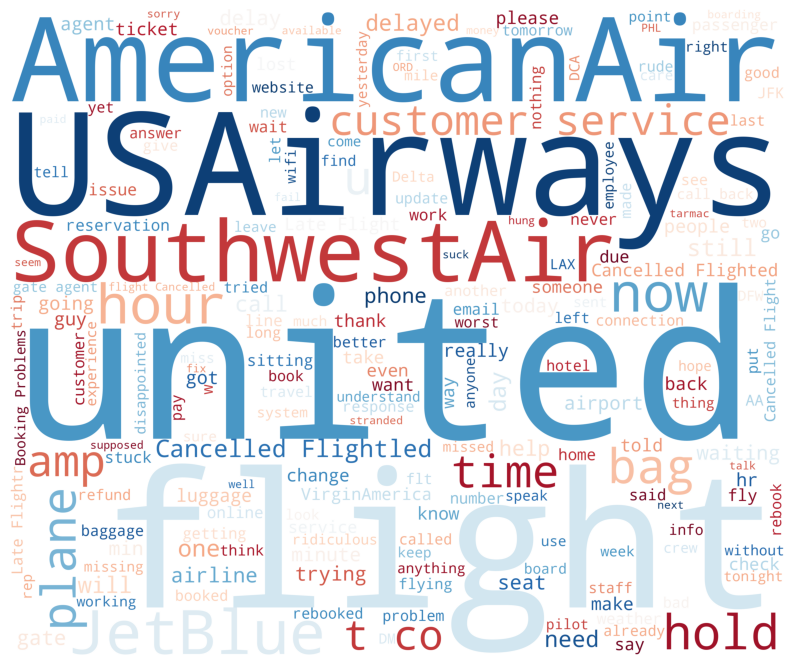

In [ ]:
plt.figure(1, figsize = (10, 10))

# Using the .imshow() method of matplotlib.pyplot to display the Word Cloud as an image.
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The cancelled, issue, delayed, booking problems, worst, customer service, missing, and stranded were some of the important recurring words observed in the negative tweets.

Word Cloud for cleaned Positive Tweets

In [ ]:
# Creating word cloud for negative tweets

# Extracting the negative tweets i.e, sentiment = positive
positive_tweets = data[data['airline_sentiment'] == 'positive']

# joining the negative tweets using space seperator, helps to convert the all rows into one string
words = ' '.join(positive_tweets['text'])

# helps to remove the \n characters from the previous output
cleaned_word = " ".join([word for word in words.split()])

In [ ]:
# creating the wordcloud using the WordCloud() method
wordcloud = WordCloud(stopwords = STOPWORDS,
                      colormap = 'RdBu',
                      background_color = 'white',
                      width = 3000,
                      height = 2500
                     ).generate(cleaned_word) # The generate() function takes one argument of the text we created, helps to generate the wordcloud

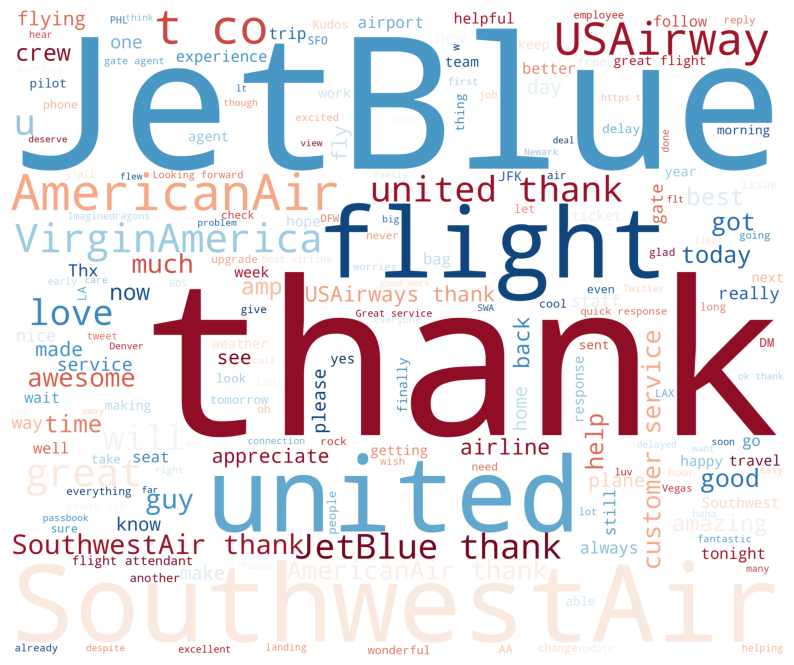

In [ ]:
plt.figure(1, figsize = (10, 10))

# Using the .imshow() method of matplotlib.pyplot to display the Word Cloud as an image.
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The love, awesome, thank, appreciate, good, helpful, great, and better were some of the important recurring words observed in the positive tweets.

Word Cloud for cleaned Neutral Tweets

In [ ]:
# Creating word cloud for negative tweets

# Extracting the negative tweets i.e, sentiment = neutral
neutral_tweets = data[data['airline_sentiment'] == 'neutral']

# joining the negative tweets using space seperator, helps to convert the all rows into one string
words = ' '.join(neutral_tweets['text'])

# helps to remove the \n characters from the previous output
cleaned_word = " ".join([word for word in words.split()])

In [ ]:
# creating the wordcloud using the WordCloud() method
wordcloud = WordCloud(stopwords = STOPWORDS,
                      colormap = 'RdBu',
                      background_color = 'white',
                      width = 3000,
                      height = 2500
                     ).generate(cleaned_word) # The generate() function takes one argument of the text we created, helps to generate the wordcloud

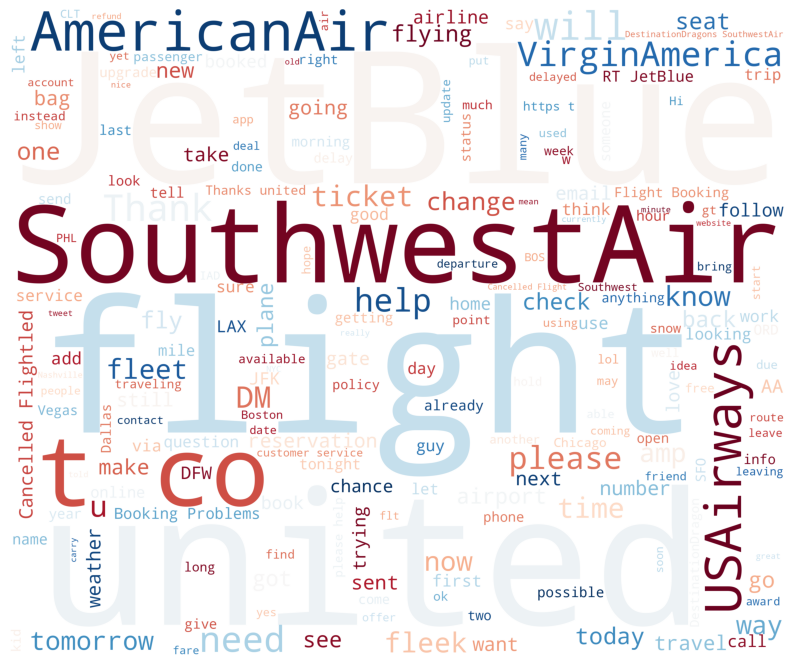

In [ ]:
plt.figure(1, figsize = (10, 10))

# Using the .imshow() method of matplotlib.pyplot to display the Word Cloud as an image.
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The available, trying, help, new, long, chance, and possible were some of the important recurring words observed in the neutral tweets.

# What is the percentage of tweets for each airline?

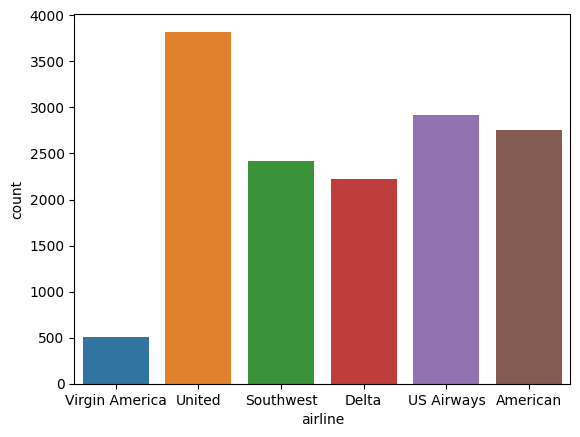

In [ ]:
sns.countplot(data=data, x='airline');

In [ ]:
data['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


*   United 26% of tweets
*   US Airways 19% of tweets
*   American 18% of tweets
*   Southwest 16% of tweets
*   Delta 15% of tweets
*   Virgin America 3% of tweets



# What is the distribution of sentiments across all the tweets?

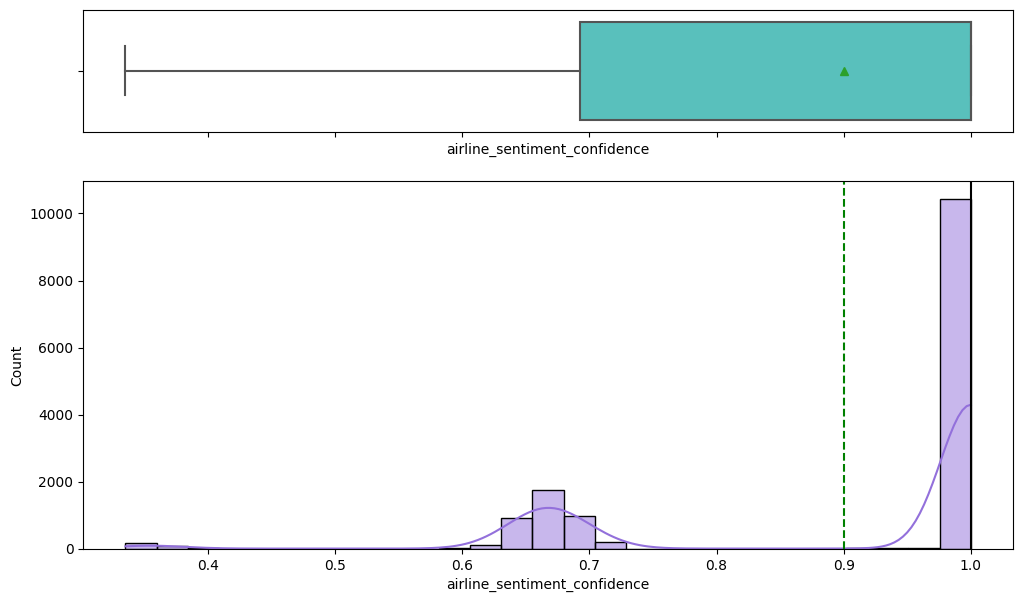

In [ ]:
histogram_boxplot(data, 'airline_sentiment_confidence', figsize=(12, 7), kde=True)

* The distribution for airline sentiment is left skewed indicating that there are several negative tweets across the various airlines.

# What is the distribution of sentiments for each airline?

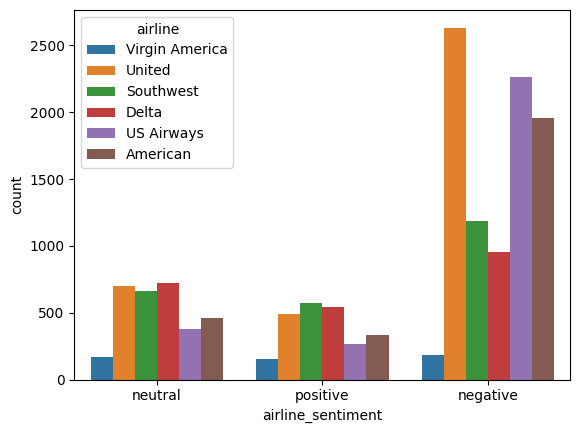

In [ ]:
sns.countplot(data=data, x='airline_sentiment', hue='airline');

* The distribution of sentiments across each airline is left skewed, there are more negative tweets compared to neutral and positive.

# What does the plot of negative reasons indicate?

The plot of negative reasons based on the negative wordcloud indicated that the airlines lack good customer service, airlines are having several delays in flights and cancellations, customers are having problems booking flights, and overall issues are constantly occurring.

# What are insights observed from EDA?



*   There are more negative tweets compared to positive and neutral tweets
across the various airlines
*   United, US Airways, and American are the top 3 discussed airlines on twitter
*   United is the most talked about airline
*   Most of the negative things customers had to say about airlines were specific to customer service, cancellations, flight delays, and booking problems.



## Data Preparation for Modeling

- Drop all unnecessary columns
- Remove html tags
- Replace contractions in string(e.g. replace I'm --> I am) and so on.\
- Remove numbers
- Tokenization
- To remove Stopwords
- Lemmatized data

In [ ]:
# Columns to drop
columns_to_drop = ['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'airline', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']

# Drop the columns
df = data.drop(columns=columns_to_drop)

In [ ]:
df.head(2)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.


In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df['text'] = df['text'].apply(lambda x: strip_html(x))

df.head()

<ipython-input-37-e4c0ba29e7f5>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

df['text'] = df['text'].apply(lambda x: replace_contractions(x))

df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [ ]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

df['text'] = df['text'].apply(lambda x: remove_numbers(x))

df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [ ]:
df['text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

In [ ]:
df.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


In [ ]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))

In [ ]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df['text'] = df.apply(lambda row: normalize(row['text']), axis=1)
df.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica not today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


In [ ]:
sentiment_score_mapping = {
    'neutral': 2,
    'positive': 1,
    'negative': 0
}

df['Score'] = df['airline_sentiment'].map(sentiment_score_mapping)

In [ ]:
df.head()

,airline_sentiment,text,Score
0,neutral,virginamerica dhepburn say,2
1,positive,virginamerica plus add commercials experience tacky,1
2,neutral,virginamerica not today must mean need take another trip,2
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,0
4,negative,virginamerica really big bad thing,0


## Model Building

### Using countvectorizer

- Intialize countvectorizer and use it for vectorization
- Store Independent and Dependent variables
- Split the data into train and test
- Build a Random Forest model on train data
- Use Cross validation to validate the score and to find optimal n_estimators
- Plot the misclassification error for each of estimators
- Test the model on testing data
- Plot the Confusion matrix
plot word cloud for top 20 important features obtained from Count vectorizer and random forest model


In [ ]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

bow_vec = CountVectorizer(max_features=2000)
data_features = bow_vec.fit_transform(df['text'])

data_features = data_features.toarray()

In [ ]:
data_features.shape

(14640, 2000)

In [ ]:
labels = df['Score']
labels = labels.astype('int')

In [ ]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [ ]:
# Using Random Forest to build model for the classification of tweets.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.7181010928961749


In [ ]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = [x for x in range(1, 25)]
base_ln

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [ ]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

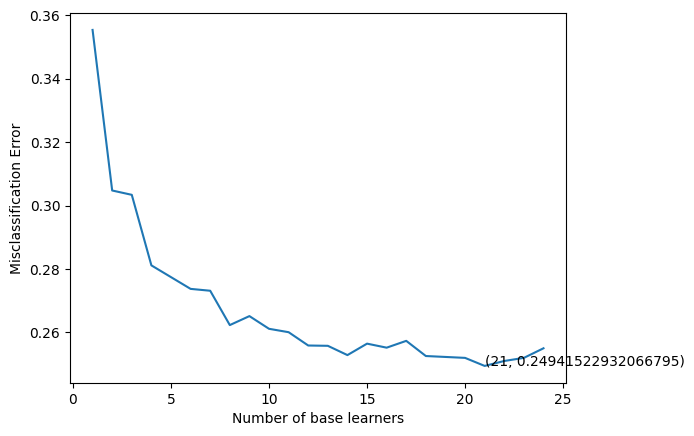

In [ ]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [ ]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7627504553734062

In [ ]:
result =  clf.predict(X_test)

[[2522   68  224]
 [ 189  410   95]
 [ 382   84  418]]
0.7627504553734062


<Axes: >

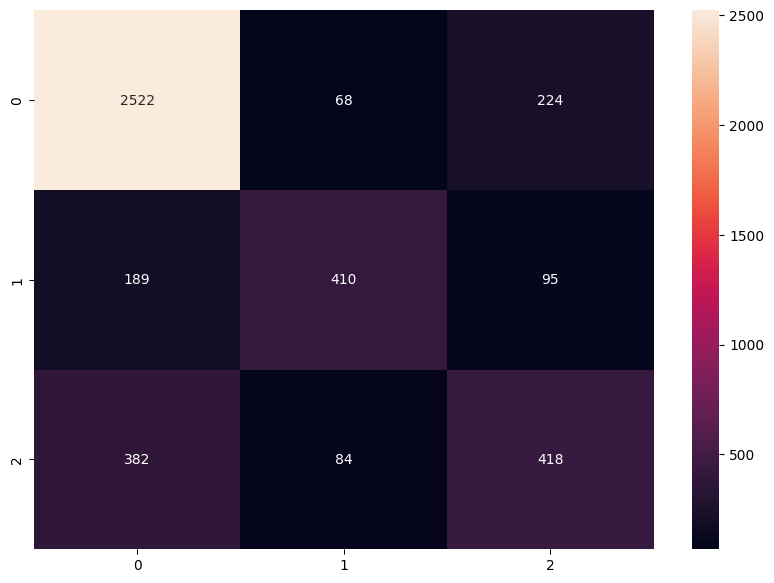

In [ ]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

print(metrics.f1_score(y_test, result,average='micro'))

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

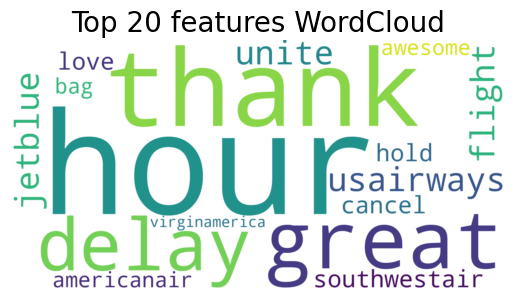

In [ ]:
all_features = bow_vec.get_feature_names_out()          # Instantiate the feature from the vectorizer
top_features=''                                         # Addition of top 20 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:20]:
    top_features+=all_features[i]
    top_features+=' '



from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000,
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 20 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

### Using TF-IDF (Term Frequency- Inverse Document Frequency)

- Intialize TFIDF and use it for vectorization
- Store Independent and Dependent variables
- Split the data into train and test
- Build a Random Forest model on train data
- Use Cross validation to validate the score and to find optimal n_estimators
- Plot the misclassification error for each of estimators
- Test the model on testing data
- Plot the Confusion matrix
plot word cloud for top 20 important features obtained from TFIDF and random forest model


In [ ]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000)
data_features = vectorizer.fit_transform(df['text'])

data_features = data_features.toarray()

data_features.shape

(14640, 2000)

In [ ]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [ ]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=5)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.6821038251366119


In [ ]:
# K - Fold Cross Validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

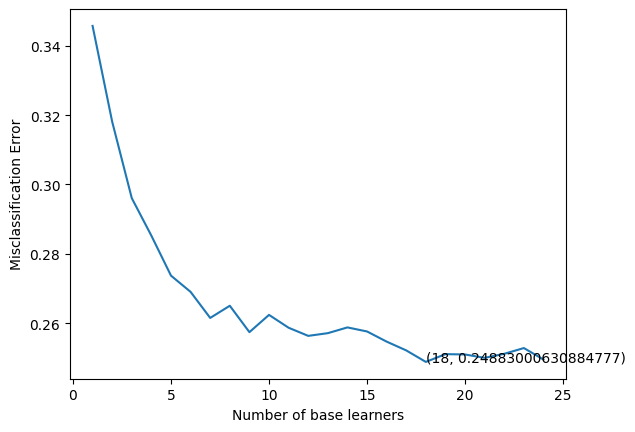

In [ ]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                              #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                             #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                                        #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [ ]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7741347905282332

In [ ]:
result = clf.predict(X_test)

[[2631   51  132]
 [ 206  393   95]
 [ 432   76  376]]
0.7741347905282331


<Axes: >

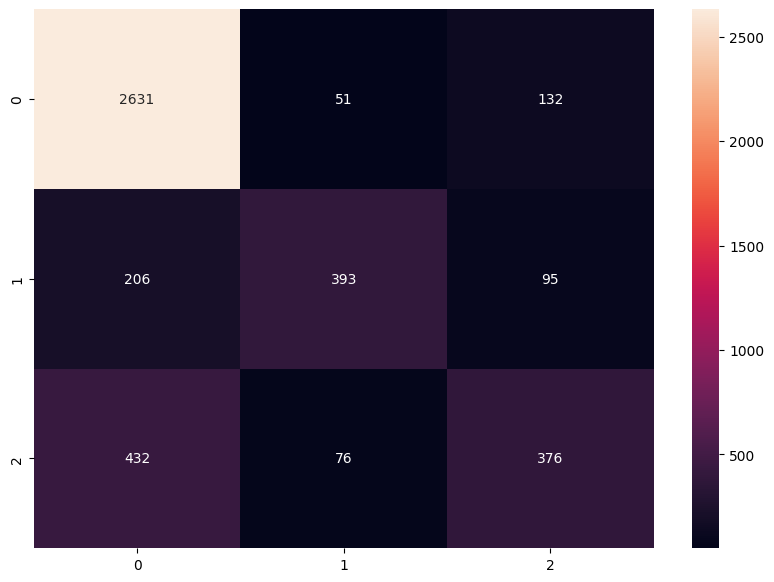

In [ ]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
result =  clf.predict(X_test)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

print(metrics.f1_score(y_test, result,average='micro'))

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

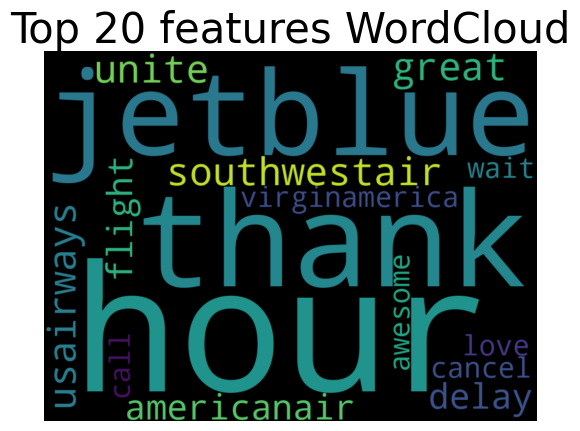

In [ ]:

all_features = vectorizer.get_feature_names_out()                                #Instantiate the feature from the vectorizer
Top_features=''                                                              #Addition of top 20 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:20]:
    Top_features+=all_features[i]
    Top_features+=' '


from wordcloud import WordCloud
wordcloud = WordCloud(background_color="Black",width=1000,
                          height=750).generate(Top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(30, 30), frameon='equal')
plt.title('Top 20 features WordCloud', fontsize=30)
plt.axis("off")
plt.show()

## Summary

---





*   We used a dataset consisting of tweets based on feedback for airlines with sentiment values of neutral, positive, and negative.
*   The goal was to build a sentiment analysis model to classify if a tweet is positive, negative, or neutral.
*   We created the Score column based on the sentiment value of each row
*   We pre-processed the data using various libraries to prepare to train the model
*   We created a Word Cloud plot to visualize frequently used words based on the sentiment of the tweets
*   We trained the model with added parameters, which also led to an increase the models accuracy
*   After building the sentiment analysis model we were able to classify a tweet sentiment based on the text
*   With more data we can also increase the accuracy and performance of our model, we're currently on using 14,640 tweets
*   With additional hyperparameter tuning we can also increase overall accuracy of our sentiment analysis model even further

